In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from lib.datasets.mnistdataset import MNIST500
import torchvision.transforms.functional as tvF
import lib.snn as snn
from datetime import datetime


In [2]:
import matplotlib
#matplotlib.use('Inline')
import matplotlib.pyplot as plt
from tqdm import tqdm

## Prepare Data
* download data, prepare DataLoader
* prepocess:
    1. Color transform. (RGB to YUV; for mnist Grey to RGB to YUV)
        * for mnist, no preprocessing, since it is in gray value
        * for Cifar-10, RGB and scale to [0.0, 1.0]. No abs
        
    2. RandomResizedCrop(size=24) for Cifar-10

In [3]:
def save_model(name, model):
    print("Saving models...")
    model.eval()

    save_model_filename = 'saved_models/' + name + '.pt'

    torch.save(model.state_dict(), save_model_filename)
    
def load_model(name, model):
    model.load_state_dict(torch.load('saved_models/' + name + '.pt'))
    
def test_acc(dataloader ,model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels =  data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))


In [13]:
BATCH_SIZE  = 4

EPOCH = 500

use_cuda = torch.cuda.is_available()

torch.manual_seed(1024)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [14]:
# # MNIST
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('./data', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,)),
#                        # the Abs was done here
#                        transforms.Lambda(lambda x: x.abs()),
#                    ])),
#     batch_size=BATCH_SIZE, shuffle=True, **kwargs)

# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('./data', train=False, 
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,)),
#                        transforms.Lambda(lambda x: x.abs()),
#                    ])),
#     batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [15]:
class Identity(): # used for skipping transforms
    def __call__(self, im):
        return im
    
def transform_cifar(is_train):
    
    return transforms.Compose([
                                transforms.RandomCrop(size=24) if is_train else Identity(),
                                transforms.RandomHorizontalFlip(p=0.5) if is_train else Identity(),
                                transforms.CenterCrop(size=24) if not is_train else Identity(),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                #transforms.Lambda(lambda x: x.abs()),
                            ])

class ConvLayer(torch.nn.Module):
    """
        out = ((in+2*padding-(kernel_size-1)-1)/stride)+1
        
        when kernel_size is: odd number, the output is only affected by stride
                             even number, use the formula.
        
        For example: if kernel size is odd, and with stride 1 then out = in, but
        channel changes. With stride 2, out is halved.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [16]:
# Cifar-10

is_train = True

trainset = MNIST500(datasetPath='./data', train=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

is_train = False

testset = MNIST500(datasetPath='./data', train=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

# Learning stats instance.
stats = snn.learningStats()

In [17]:
data, label = next(iter(trainloader))

In [18]:
torch.max(data[:10])

tensor(1.)

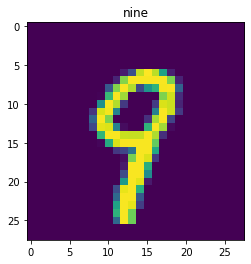

In [19]:
idx = 2
plt.imshow(data[idx].permute(1,2,0).squeeze())
plt.title(classes[label[idx]])
plt.show()

In [20]:
class Raw_CNN(nn.Module):
    def __init__(self):
        super(Raw_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 5, padding=1, bias=True)
        self.conv2 = nn.Conv2d(12, 64, 5, padding=1, bias=True)
        self.m1 = nn.MaxPool2d(2)
        self.m2 = nn.MaxPool2d(2,padding=1)
        self.fc1 = nn.Linear(64 * 6 * 6, 10, bias=True)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #(3, 24, 24) -> (64, 20, 20)
        x = self.m1(x) #(64, 10, 10)
        x = F.relu(self.conv2(x)) #(64, 6, 6)
        x = self.m2(x) #(64, 3, 3)
        x = x.view(-1, 64 * 6 * 6)    #(64*3*3)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

class Tailored_CNN(nn.Module):
    def __init__(self):
        super(Tailored_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 5, padding=1, bias=False)
        self.conv2 = nn.Conv2d(12, 64, 5, padding=1, bias=False)
        self.a1 = nn.AvgPool2d(2)
        self.a2 = nn.AvgPool2d(2,padding=1)
        self.fc1 = nn.Linear(64 * 6 * 6, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #(3, 24, 24) -> (64, 20, 20)
        x = self.a1(x) #(64, 10, 10)
        x = F.relu(self.conv2(x)) #(64, 6, 6)
        x = self.a2(x) #(64, 3, 3)
        x = x.view(-1, 64 * 6 * 6)    #(64*3*3)
        x = self.fc1(x) #(10*1*1)
        return F.log_softmax(x, dim=1)

In [21]:
raw_cnn = Raw_CNN().to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(raw_cnn.parameters(), lr=0.001)
stats = snn.learningStats()

## Training

# training loop
for epoch in tqdm(range(EPOCH)):
    # Reset training stats.
    stats.training.reset()
    tSt = datetime.now()
    raw_cnn.train()    
    # Training loop.
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = raw_cnn(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        # Gather training loss stats.
        stats.training.lossSum += loss.cpu().data.item()

        # Gather the training stats.
        _, predicted = torch.max(outputs.data, 1)
        
        stats.training.correctSamples += torch.sum(predicted == labels).data.item()
        stats.training.numSamples += len(labels)

        # Display training stats.
        # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
    # Update training stats.
    stats.training.update()
    # Reset testing stats.
    stats.testing.reset()
    raw_cnn.eval()    
    # Testing loop.
    # Same steps as Training loops except loss backpropagation and weight update.
    for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = raw_cnn.forward(inputs)
        _, predicted = torch.max(outputs.data, 1)

        stats.testing.correctSamples += torch.sum(predicted == labels).data.item()
        stats.testing.numSamples += len(labels)

        loss = criterion(outputs, labels)
        stats.testing.lossSum += loss.cpu().data.item()
        
        # if i%10 == 0: stats.print(epoch, i)


    # Update stats.
    stats.testing.update()
    if epoch%10==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())
print('Finished Training')
save_model('raw_cnn', raw_cnn)

  0%|          | 1/500 [00:00<05:44,  1.45it/s]


Epoch :          0,     689.5740 ms elapsed
loss = 0.31526      (min = 0.31526     )  	accuracy = 0.622      (max = 0.622     )
loss = 0.13775      (min = 0.13775     )  	accuracy = 0.812      (max = 0.812     )


  2%|▏         | 11/500 [00:05<03:44,  2.18it/s]


Epoch :         10,     448.6770 ms elapsed
loss = 0.00027424   (min = 0.00027424  )  	accuracy = 1          (max = 1         )
loss = 0.047793     (min = 0.043856    )  	accuracy = 0.942      (max = 0.946     )


  4%|▍         | 21/500 [00:09<03:34,  2.23it/s]


Epoch :         20,     448.2440 ms elapsed
loss = 5.6014e-05   (min = 5.6014e-05  )  	accuracy = 1          (max = 1         )
loss = 0.052513     (min = 0.043856    )  	accuracy = 0.944      (max = 0.946     )


  6%|▌         | 31/500 [00:14<03:40,  2.13it/s]


Epoch :         30,     454.0980 ms elapsed
loss = 1.926e-05    (min = 1.926e-05   )  	accuracy = 1          (max = 1         )
loss = 0.056133     (min = 0.043856    )  	accuracy = 0.942      (max = 0.946     )


  8%|▊         | 41/500 [00:19<03:30,  2.18it/s]


Epoch :         40,     446.5300 ms elapsed
loss = 7.8828e-06   (min = 7.8828e-06  )  	accuracy = 1          (max = 1         )
loss = 0.060058     (min = 0.043856    )  	accuracy = 0.94       (max = 0.946     )


 10%|█         | 51/500 [00:23<03:29,  2.14it/s]


Epoch :         50,     475.5330 ms elapsed
loss = 3.4263e-06   (min = 3.4263e-06  )  	accuracy = 1          (max = 1         )
loss = 0.063191     (min = 0.043856    )  	accuracy = 0.94       (max = 0.946     )


 12%|█▏        | 61/500 [00:28<03:20,  2.19it/s]


Epoch :         60,     456.0190 ms elapsed
loss = 1.5605e-06   (min = 1.5605e-06  )  	accuracy = 1          (max = 1         )
loss = 0.065604     (min = 0.043856    )  	accuracy = 0.94       (max = 0.946     )


 14%|█▍        | 71/500 [00:33<04:24,  1.62it/s]


Epoch :         70,     775.5440 ms elapsed
loss = 7.345e-07    (min = 7.345e-07   )  	accuracy = 1          (max = 1         )
loss = 0.069566     (min = 0.043856    )  	accuracy = 0.942      (max = 0.946     )


 16%|█▌        | 81/500 [00:38<03:15,  2.15it/s]


Epoch :         80,     455.3550 ms elapsed
loss = 3.472e-07    (min = 3.472e-07   )  	accuracy = 1          (max = 1         )
loss = 0.072553     (min = 0.043856    )  	accuracy = 0.942      (max = 0.946     )


 18%|█▊        | 91/500 [00:43<04:15,  1.60it/s]


Epoch :         90,     759.7570 ms elapsed
loss = 1.6445e-07   (min = 1.6445e-07  )  	accuracy = 1          (max = 1         )
loss = 0.076444     (min = 0.043856    )  	accuracy = 0.942      (max = 0.946     )


 20%|██        | 101/500 [00:48<03:06,  2.14it/s]


Epoch :        100,     468.7700 ms elapsed
loss = 8.0407e-08   (min = 8.0407e-08  )  	accuracy = 1          (max = 1         )
loss = 0.078281     (min = 0.043856    )  	accuracy = 0.942      (max = 0.946     )


 22%|██▏       | 111/500 [00:53<03:30,  1.85it/s]


Epoch :        110,     721.4090 ms elapsed
loss = 3.8922e-08   (min = 3.8922e-08  )  	accuracy = 1          (max = 1         )
loss = 0.081717     (min = 0.043856    )  	accuracy = 0.944      (max = 0.946     )


 24%|██▍       | 121/500 [00:59<04:03,  1.55it/s]


Epoch :        120,     677.0510 ms elapsed
loss = 1.9133e-08   (min = 1.9133e-08  )  	accuracy = 1          (max = 1         )
loss = 0.085075     (min = 0.043856    )  	accuracy = 0.944      (max = 0.946     )


 26%|██▌       | 131/500 [01:05<03:04,  2.00it/s]


Epoch :        130,     452.9850 ms elapsed
loss = 8.7619e-09   (min = 8.7619e-09  )  	accuracy = 1          (max = 1         )
loss = 0.087846     (min = 0.043856    )  	accuracy = 0.944      (max = 0.946     )


 28%|██▊       | 141/500 [01:09<02:47,  2.14it/s]


Epoch :        140,     462.0040 ms elapsed
loss = 3.7551e-09   (min = 3.7551e-09  )  	accuracy = 1          (max = 1         )
loss = 0.091266     (min = 0.043856    )  	accuracy = 0.944      (max = 0.946     )


 30%|███       | 151/500 [01:14<02:40,  2.18it/s]


Epoch :        150,     450.1520 ms elapsed
loss = 1.1921e-09   (min = 1.1921e-09  )  	accuracy = 1          (max = 1         )
loss = 0.093693     (min = 0.043856    )  	accuracy = 0.944      (max = 0.946     )


 32%|███▏      | 161/500 [01:19<02:34,  2.19it/s]


Epoch :        160,     442.4590 ms elapsed
loss = 1.1921e-10   (min = 1.1921e-10  )  	accuracy = 1          (max = 1         )
loss = 0.096778     (min = 0.043856    )  	accuracy = 0.944      (max = 0.946     )


 34%|███▍      | 171/500 [01:23<02:29,  2.21it/s]


Epoch :        170,     449.9020 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.10019      (min = 0.043856    )  	accuracy = 0.946      (max = 0.946     )


 36%|███▌      | 181/500 [01:28<02:28,  2.15it/s]


Epoch :        180,     467.8930 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.102        (min = 0.043856    )  	accuracy = 0.946      (max = 0.946     )


 38%|███▊      | 191/500 [01:33<02:21,  2.18it/s]


Epoch :        190,     466.2340 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.10563      (min = 0.043856    )  	accuracy = 0.946      (max = 0.946     )


 40%|████      | 201/500 [01:37<02:19,  2.14it/s]


Epoch :        200,     469.3210 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.10872      (min = 0.043856    )  	accuracy = 0.946      (max = 0.946     )


 42%|████▏     | 211/500 [01:42<02:15,  2.13it/s]


Epoch :        210,     459.5840 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.11161      (min = 0.043856    )  	accuracy = 0.946      (max = 0.946     )


 44%|████▍     | 221/500 [01:47<02:16,  2.05it/s]


Epoch :        220,     487.7240 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.11405      (min = 0.043856    )  	accuracy = 0.946      (max = 0.946     )


 46%|████▌     | 231/500 [01:51<02:09,  2.08it/s]


Epoch :        230,     483.9490 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.11641      (min = 0.043856    )  	accuracy = 0.946      (max = 0.946     )


 48%|████▊     | 241/500 [01:56<02:04,  2.09it/s]


Epoch :        240,     483.5260 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.11855      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 50%|█████     | 251/500 [02:01<01:58,  2.10it/s]


Epoch :        250,     488.2950 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.12062      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 52%|█████▏    | 261/500 [02:06<01:51,  2.15it/s]


Epoch :        260,     475.2460 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.1222       (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 54%|█████▍    | 271/500 [02:10<01:43,  2.22it/s]


Epoch :        270,     449.5050 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.12363      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 56%|█████▌    | 281/500 [02:15<01:38,  2.22it/s]


Epoch :        280,     450.5270 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.12507      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 58%|█████▊    | 291/500 [02:19<01:34,  2.21it/s]


Epoch :        290,     452.3090 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.12596      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 60%|██████    | 301/500 [02:24<01:30,  2.19it/s]


Epoch :        300,     453.0030 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.12667      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 62%|██████▏   | 311/500 [02:28<01:25,  2.22it/s]


Epoch :        310,     446.0960 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.12762      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 64%|██████▍   | 321/500 [02:33<01:20,  2.21it/s]


Epoch :        320,     446.7310 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.12828      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 66%|██████▌   | 331/500 [02:37<01:16,  2.21it/s]


Epoch :        330,     451.4730 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.12903      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 68%|██████▊   | 341/500 [02:42<01:11,  2.21it/s]


Epoch :        340,     453.8960 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.12957      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 70%|███████   | 351/500 [02:46<01:07,  2.22it/s]


Epoch :        350,     449.6290 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.13005      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 72%|███████▏  | 361/500 [02:51<01:02,  2.22it/s]


Epoch :        360,     445.3470 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.13051      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 74%|███████▍  | 371/500 [02:55<00:58,  2.22it/s]


Epoch :        370,     450.9550 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.13101      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 76%|███████▌  | 381/500 [03:00<00:54,  2.19it/s]


Epoch :        380,     463.7870 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.1313       (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 78%|███████▊  | 391/500 [03:04<00:50,  2.16it/s]


Epoch :        390,     451.7930 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.13168      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 80%|████████  | 401/500 [03:09<00:44,  2.20it/s]


Epoch :        400,     450.5520 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.13204      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 82%|████████▏ | 411/500 [03:14<00:40,  2.20it/s]


Epoch :        410,     448.9190 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.13239      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 84%|████████▍ | 421/500 [03:18<00:35,  2.20it/s]


Epoch :        420,     459.3830 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.13263      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 86%|████████▌ | 431/500 [03:23<00:32,  2.15it/s]


Epoch :        430,     480.3050 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.13292      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 88%|████████▊ | 441/500 [03:27<00:27,  2.18it/s]


Epoch :        440,     449.0330 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.13322      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 90%|█████████ | 451/500 [03:32<00:22,  2.19it/s]


Epoch :        450,     468.2830 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.13348      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 92%|█████████▏| 461/500 [03:37<00:17,  2.18it/s]


Epoch :        460,     443.6230 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.1337       (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 94%|█████████▍| 471/500 [03:41<00:13,  2.22it/s]


Epoch :        470,     447.9960 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.13398      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 96%|█████████▌| 481/500 [03:46<00:08,  2.22it/s]


Epoch :        480,     446.6770 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.13418      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


 98%|█████████▊| 491/500 [03:50<00:04,  2.17it/s]


Epoch :        490,     445.1080 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.13445      (min = 0.043856    )  	accuracy = 0.946      (max = 0.948     )


100%|██████████| 500/500 [03:54<00:00,  2.20it/s]

Finished Training
Saving models...


In [23]:
test_acc(testloader, raw_cnn)

Accuracy of the network on the 10000 test images: 94 %


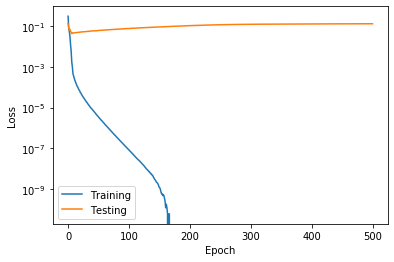

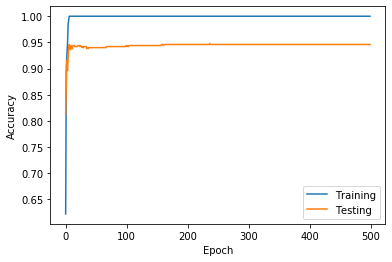

In [24]:
# Plot the results.
plt.figure(1)
plt.semilogy(stats.training.lossLog, label='Training')
plt.semilogy(stats.testing.lossLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(stats.training.accuracyLog, label='Training')
plt.plot(stats.testing.accuracyLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [25]:
tailored_cnn = Tailored_CNN().to(device)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tailored_cnn.parameters(), lr=0.001)
stats = snn.learningStats()
## Training
# training loop
for epoch in tqdm(range(EPOCH)):
    # Reset training stats.
    stats.training.reset()
    tSt = datetime.now()
    tailored_cnn.train()    
    # Training loop.
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = tailored_cnn(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        # Gather training loss stats.
        stats.training.lossSum += loss.cpu().data.item()

        # Gather the training stats.
        _, predicted = torch.max(outputs.data, 1)
        
        stats.training.correctSamples += torch.sum(predicted == labels).data.item()
        stats.training.numSamples += len(labels)

        # Display training stats.
        # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
    # Update training stats.
    stats.training.update()
    # Reset testing stats.
    stats.testing.reset()
    tailored_cnn.eval()    
    # Testing loop.
    # Same steps as Training loops except loss backpropagation and weight update.
    for i, data in enumerate(testloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = tailored_cnn.forward(inputs)
        _, predicted = torch.max(outputs.data, 1)

        stats.testing.correctSamples += torch.sum(predicted == labels).data.item()
        stats.testing.numSamples += len(labels)

        loss = criterion(outputs, labels)
        stats.testing.lossSum += loss.cpu().data.item()
        
        # if i%10 == 0: stats.print(epoch, i)


    # Update stats.
    stats.testing.update()
    if epoch%10==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())

print('Finished Training')
save_model('tailor_cnn', tailored_cnn)

  0%|          | 1/500 [00:00<03:40,  2.27it/s]


Epoch :          0,     440.8630 ms elapsed
loss = 0.31956      (min = 0.31956     )  	accuracy = 0.602      (max = 0.602     )
loss = 0.1683       (min = 0.1683      )  	accuracy = 0.808      (max = 0.808     )


  2%|▏         | 11/500 [00:04<03:20,  2.44it/s]


Epoch :         10,     406.2970 ms elapsed
loss = 0.0062208    (min = 0.0030943   )  	accuracy = 0.994      (max = 0.998     )
loss = 0.069535     (min = 0.062021    )  	accuracy = 0.918      (max = 0.92      )


  4%|▍         | 21/500 [00:08<03:16,  2.43it/s]


Epoch :         20,     407.2830 ms elapsed
loss = 0.00011676   (min = 0.00011676  )  	accuracy = 1          (max = 1         )
loss = 0.070472     (min = 0.059815    )  	accuracy = 0.934      (max = 0.936     )


  6%|▌         | 31/500 [00:12<03:12,  2.44it/s]


Epoch :         30,     410.3890 ms elapsed
loss = 3.7294e-05   (min = 3.7294e-05  )  	accuracy = 1          (max = 1         )
loss = 0.080778     (min = 0.059815    )  	accuracy = 0.932      (max = 0.936     )


  8%|▊         | 41/500 [00:16<03:08,  2.44it/s]


Epoch :         40,     406.6520 ms elapsed
loss = 1.5613e-05   (min = 1.5613e-05  )  	accuracy = 1          (max = 1         )
loss = 0.089979     (min = 0.059815    )  	accuracy = 0.93       (max = 0.936     )


 10%|█         | 51/500 [00:20<03:03,  2.44it/s]


Epoch :         50,     407.5620 ms elapsed
loss = 7.4093e-06   (min = 7.4093e-06  )  	accuracy = 1          (max = 1         )
loss = 0.098361     (min = 0.059815    )  	accuracy = 0.928      (max = 0.936     )


 12%|█▏        | 61/500 [00:25<03:03,  2.39it/s]


Epoch :         60,     409.4340 ms elapsed
loss = 3.6102e-06   (min = 3.6102e-06  )  	accuracy = 1          (max = 1         )
loss = 0.10597      (min = 0.059815    )  	accuracy = 0.922      (max = 0.936     )


 14%|█▍        | 71/500 [00:29<03:20,  2.14it/s]


Epoch :         70,     414.6100 ms elapsed
loss = 1.7764e-06   (min = 1.7764e-06  )  	accuracy = 1          (max = 1         )
loss = 0.11428      (min = 0.059815    )  	accuracy = 0.922      (max = 0.936     )


 16%|█▌        | 81/500 [00:33<02:52,  2.42it/s]


Epoch :         80,     414.4480 ms elapsed
loss = 8.7659e-07   (min = 8.7659e-07  )  	accuracy = 1          (max = 1         )
loss = 0.12228      (min = 0.059815    )  	accuracy = 0.922      (max = 0.936     )


 18%|█▊        | 91/500 [00:38<02:47,  2.44it/s]


Epoch :         90,     406.4220 ms elapsed
loss = 4.4357e-07   (min = 4.4357e-07  )  	accuracy = 1          (max = 1         )
loss = 0.12988      (min = 0.059815    )  	accuracy = 0.922      (max = 0.936     )


 20%|██        | 101/500 [00:42<02:43,  2.44it/s]


Epoch :        100,     411.3550 ms elapsed
loss = 2.163e-07    (min = 2.163e-07   )  	accuracy = 1          (max = 1         )
loss = 0.13786      (min = 0.059815    )  	accuracy = 0.924      (max = 0.936     )


 22%|██▏       | 111/500 [00:46<02:38,  2.45it/s]


Epoch :        110,     405.1080 ms elapsed
loss = 1.0866e-07   (min = 1.0866e-07  )  	accuracy = 1          (max = 1         )
loss = 0.14575      (min = 0.059815    )  	accuracy = 0.92       (max = 0.936     )


 24%|██▍       | 121/500 [00:50<02:35,  2.44it/s]


Epoch :        120,     405.6390 ms elapsed
loss = 5.5253e-08   (min = 5.5253e-08  )  	accuracy = 1          (max = 1         )
loss = 0.1542       (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 26%|██▌       | 131/500 [00:54<02:31,  2.43it/s]


Epoch :        130,     408.3800 ms elapsed
loss = 2.7418e-08   (min = 2.7418e-08  )  	accuracy = 1          (max = 1         )
loss = 0.16298      (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 28%|██▊       | 141/500 [00:58<02:26,  2.44it/s]


Epoch :        140,     410.9510 ms elapsed
loss = 1.3113e-08   (min = 1.3113e-08  )  	accuracy = 1          (max = 1         )
loss = 0.17044      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 30%|███       | 151/500 [01:02<02:22,  2.45it/s]


Epoch :        150,     407.5610 ms elapsed
loss = 6.6161e-09   (min = 6.6161e-09  )  	accuracy = 1          (max = 1         )
loss = 0.17891      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 32%|███▏      | 161/500 [01:06<02:23,  2.36it/s]


Epoch :        160,     410.5960 ms elapsed
loss = 3.3379e-09   (min = 3.2187e-09  )  	accuracy = 1          (max = 1         )
loss = 0.18744      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 34%|███▍      | 171/500 [01:11<02:17,  2.40it/s]


Epoch :        170,     416.5260 ms elapsed
loss = 8.9407e-10   (min = 8.9407e-10  )  	accuracy = 1          (max = 1         )
loss = 0.19514      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 36%|███▌      | 181/500 [01:15<02:13,  2.40it/s]


Epoch :        180,     422.1130 ms elapsed
loss = 2.3842e-10   (min = 1.7881e-10  )  	accuracy = 1          (max = 1         )
loss = 0.20305      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 38%|███▊      | 191/500 [01:19<02:24,  2.14it/s]


Epoch :        190,     494.2610 ms elapsed
loss = 5.9605e-11   (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.21098      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 40%|████      | 201/500 [01:23<02:08,  2.33it/s]


Epoch :        200,     432.1640 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.21821      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 42%|████▏     | 211/500 [01:28<02:00,  2.40it/s]


Epoch :        210,     410.0510 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.22561      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 44%|████▍     | 221/500 [01:32<02:03,  2.26it/s]


Epoch :        220,     451.3310 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.23272      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 46%|████▌     | 231/500 [01:37<02:13,  2.01it/s]


Epoch :        230,     470.6290 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.23988      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 48%|████▊     | 241/500 [01:41<01:58,  2.19it/s]


Epoch :        240,     445.7900 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.24578      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 50%|█████     | 251/500 [01:46<01:46,  2.34it/s]


Epoch :        250,     417.4210 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.25134      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 52%|█████▏    | 261/500 [01:50<01:38,  2.44it/s]


Epoch :        260,     409.8960 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.25574      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 54%|█████▍    | 271/500 [01:54<01:34,  2.43it/s]


Epoch :        270,     411.4690 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.25963      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 56%|█████▌    | 281/500 [01:58<01:29,  2.45it/s]


Epoch :        280,     409.1350 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.26336      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 58%|█████▊    | 291/500 [02:02<01:25,  2.44it/s]


Epoch :        290,     405.7580 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.26549      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 60%|██████    | 301/500 [02:06<01:21,  2.45it/s]


Epoch :        300,     408.8990 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.26722      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 62%|██████▏   | 311/500 [02:10<01:17,  2.44it/s]


Epoch :        310,     410.2480 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.26945      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 64%|██████▍   | 321/500 [02:14<01:13,  2.45it/s]


Epoch :        320,     404.6940 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.27129      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 66%|██████▌   | 331/500 [02:18<01:09,  2.45it/s]


Epoch :        330,     407.9640 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.27277      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 68%|██████▊   | 341/500 [02:23<01:09,  2.27it/s]


Epoch :        340,     416.4180 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.27427      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 70%|███████   | 351/500 [02:27<01:06,  2.24it/s]


Epoch :        350,     445.0060 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.27552      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 72%|███████▏  | 361/500 [02:32<00:59,  2.35it/s]


Epoch :        360,     408.6190 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.27681      (min = 0.059815    )  	accuracy = 0.916      (max = 0.936     )


 74%|███████▍  | 371/500 [02:36<00:54,  2.36it/s]


Epoch :        370,     412.5840 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.27808      (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 76%|███████▌  | 381/500 [02:40<00:50,  2.38it/s]


Epoch :        380,     417.0290 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.27882      (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 78%|███████▊  | 391/500 [02:44<00:46,  2.37it/s]


Epoch :        390,     411.1700 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.27956      (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 80%|████████  | 401/500 [02:48<00:41,  2.37it/s]


Epoch :        400,     419.0740 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.28056      (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 82%|████████▏ | 411/500 [02:53<00:40,  2.19it/s]


Epoch :        410,     457.9800 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.28113      (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 84%|████████▍ | 421/500 [02:57<00:34,  2.28it/s]


Epoch :        420,     435.0940 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.28206      (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 86%|████████▌ | 431/500 [03:02<00:31,  2.23it/s]


Epoch :        430,     440.0850 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.28257      (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 88%|████████▊ | 441/500 [03:07<00:26,  2.23it/s]


Epoch :        440,     425.6790 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.28326      (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 90%|█████████ | 451/500 [03:11<00:24,  1.98it/s]


Epoch :        450,     524.6380 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.28384      (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 92%|█████████▏| 461/500 [03:16<00:17,  2.29it/s]


Epoch :        460,     412.0790 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.28449      (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 94%|█████████▍| 471/500 [03:20<00:12,  2.29it/s]


Epoch :        470,     421.2020 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.28495      (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 96%|█████████▌| 481/500 [03:25<00:08,  2.34it/s]


Epoch :        480,     424.3360 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.2856       (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


 98%|█████████▊| 491/500 [03:29<00:03,  2.36it/s]


Epoch :        490,     432.7300 ms elapsed
loss = 0            (min = 0           )  	accuracy = 1          (max = 1         )
loss = 0.28605      (min = 0.059815    )  	accuracy = 0.918      (max = 0.936     )


100%|██████████| 500/500 [03:33<00:00,  2.25it/s]

Finished Training
Saving models...


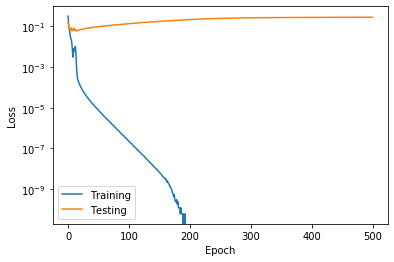

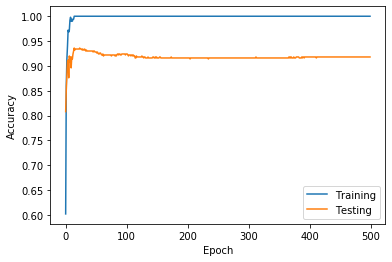

In [27]:
# Plot the results.
plt.figure(1)
plt.semilogy(stats.training.lossLog, label='Training')
plt.semilogy(stats.testing.lossLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure(2)
plt.plot(stats.training.accuracyLog, label='Training')
plt.plot(stats.testing.accuracyLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
test_acc(testloader, tailored_cnn)

Accuracy of the network on the 10000 test images: 91 %


In [29]:
load_model('tailor_cnn', tailored_cnn)

# how to access the weights for each layer

In [30]:
for k in iter(tailored_cnn.state_dict()):
    print("Layer {}".format(k))
    print(tailored_cnn.state_dict()[k].shape)

Layer conv1.weight
torch.Size([12, 1, 5, 5])
Layer conv2.weight
torch.Size([64, 12, 5, 5])
Layer fc1.weight
torch.Size([10, 2304])


In [31]:
tailored_cnn.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-0.0720,  0.2392,  0.2181,  0.0532,  0.2760],
                        [ 0.3195,  0.3805,  0.5051,  0.3752,  0.2410],
                        [ 0.0789,  0.4169,  0.4111,  0.1030,  0.1592],
                        [ 0.0211,  0.3118,  0.2989,  0.0875,  0.1523],
                        [ 0.1148,  0.1689, -0.0975, -0.2469, -0.2345]]],
              
              
                      [[[-0.1299, -0.2203, -0.1893, -0.0390,  0.0571],
                        [ 0.1845, -0.1001,  0.1539, -0.0259,  0.3271],
                        [ 0.1931,  0.1292,  0.3173,  0.4069,  0.3780],
                        [ 0.1548,  0.3684,  0.4479,  0.5769,  0.2614],
                        [-0.0347, -0.0011,  0.0641,  0.4637,  0.0597]]],
              
              
                      [[[ 0.2774,  0.3690,  0.4362,  0.4219,  0.3936],
                        [ 0.0350,  0.2315,  0.4570,  0.4341,  0.0970],
                        [-0.0939, -0.0992,  0.2931,  0